In [1]:
%load_ext autoreload
%autoreload 2

## Bag-Of-Words Model

In [30]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import numpy as np
import pandas as pd 
from src.utils import train_test_split, aggregate_samples, remove_hashtag_links
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from src.preprocessing import TextDataset
import torch
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, roc_auc_score
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation, LoggingHandler
import logging
from copy import deepcopy
from sklearn.decomposition import PCA
from huggingface_hub import notebook_login
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import re
import nltk
from nltk.corpus import stopwords
from src.cross_val import KFoldSplitter
from nltk.stem import WordNetLemmatizer
from src.feature_extraction import lemmatize_text

tqdm.pandas()

In [3]:

import logging

# Configure the logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Log message format
    handlers=[
        logging.FileHandler("logs/bow.log"),  # Log messages to a file
        logging.StreamHandler()         # Log messages to the console
    ]
)

# Example usage
logger = logging.getLogger(__name__)

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [6]:
train_data, _ = train_test_split()

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


In [7]:
all_df = pd.concat(train_data)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", )
all_df['tokens'] = all_df['Tweet'].progress_apply(tokenizer.tokenize)

target_words = [
    "goal", "penalty", "halftime", "full-time", "yellow", "red",
    "kickoff", "extra time", "stoppage time", "foul", "offside", "handball",
    "save", "tackle", "dribble", "corner", "substitution", "header",
    "free kick", "throw-in", "assist", "hat-trick", "own goal", "victory",
    "defeat", "draw", "win", "loss", "tie", "comeback", "goalkeeper",
    "striker", "midfielder", "defender", "referee", "fans", "var", "gooal"
]
target_words = set(tokenizer.tokenize(" ".join(target_words)))

def is_valid_text(t):
    for w in t:
        if w in target_words:
            return True
        
    return False

all_df['is_valid']= all_df['tokens'].progress_apply(is_valid_text)

100%|██████████| 1472980/1472980 [00:02<00:00, 497669.86it/s]


In [8]:
valid_df = all_df.query("is_valid == 1")

In [28]:
valid_df

ID  MatchID  PeriodID  EventType      Timestamp  \
0  14         0_0        0         0          0  1403725802000   
   29         0_0        0         0          0  1403725806000   
   34         0_0        0         0          0  1403725806000   
   36         0_0        0         0          0  1403725807000   
   76         0_0        0         0          0  1403725818000   
...           ...      ...       ...        ...            ...   
19 155330  19_129       19       129          1  1403560798000   
   155360  19_129       19       129          1  1403560798000   
   155448  19_129       19       129          1  1403560799000   
   155458  19_129       19       129          1  1403560799000   
   155480  19_129       19       129          1  1403560800000   

                                                       Tweet  \
0  14      Let's go Honduras, with a little help from Fra...   
   29      The more goals France scores today the less go...   
   34      #ECU must match or better #SUI performance aga...   
   36      Robbie Fowler predicting a Honduras win? #Worl...   
   76      I’m following Honduras versus Switzerland in t...   
...                                                      ...   
19 155330            Great win can't wait for next game #MEX   
   155360  If they wouldn't have robbed Mexico in the fir...   
   155448  Round of 16 - 29 de Junio #MEX vs #NED #Brasil...   
   155458  Holland better not let up, El Tri is coming fo...   
   155480  Brazil vs Mexico in the knockout rounds? I'm r...   

                                                      tokens  is_valid  
0  14      [let, ', s, go, honduras, ,, with, a, little, ...      True  
   29      [the, more, goals, france, scores, today, the,...      True  
   34      [#, ec, ##u, must, match, or, better, #, sui, ...      True  
   36      [robbie, fowler, predicting, a, honduras, win,...      True  
   76      [i, ’, m, following, honduras, versus, switzer...      True  
...                                                      ...       ...  
19 155330  [great, win, can, ', t, wait, for, next, game,...      True  
   155360  [if, they, wouldn, ', t, have, robbed, mexico,...      True  
   155448  [round, of, 16, -, 29, de, jun, ##io, #, me, #...      True  
   155458  [holland, better, not, let, up, ,, el, tri, is...      True  
   155480  [brazil, vs, mexico, in, the, knockout, rounds...      True  

[593434 rows x 8 columns]

## Cross validation

In [9]:
classifiers = [LogisticRegression(), RandomForestClassifier(), RandomForestClassifier(max_depth=5), DecisionTreeClassifier(), MLPClassifier()]


In [14]:
clf = classifiers[2]

In [33]:
valid_df['tokens'] = valid_df['Tweet'].progress_apply(lemmatize_text)

[nltk_data] Downloading package punkt to /home/pedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/pedro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/pedro/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pedro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
100%|██████████| 593434/593434 [02:35<00:00, 3804.42it/s]
/tmp/ipykernel_958003/1007625579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['tokens'] = valid_df['Tweet'].progress_apply(lemmatize_text)


In [45]:
splitter = KFoldSplitter([0,1,2,5,12,19,7,11,13,18], val_size=4)
splits = splitter.split()
folds = np.random.choice(splits, size=10)

classifiers = [LogisticRegression(), RandomForestClassifier(), RandomForestClassifier(max_depth=5), DecisionTreeClassifier(), MLPClassifier()]

performances = {}

for clf in classifiers:
    logger.info(f"\n\nUsing Classifier {clf}")

    accuracies_list = []
    for i, split_idx in tqdm(enumerate(folds)):
        
        train_indices, val_indices = split_idx['train_indices'], split_idx['val_indices']

        train_df = aggregate_samples(valid_df, train_indices, max_tweet_size = 10, tweet_col='tokens')
        train_df = remove_hashtag_links(train_df, tweet_col="tokens")

        val_df = aggregate_samples(valid_df, val_indices, max_tweet_size = 10, tweet_col='tokens')
        val_df = remove_hashtag_links(val_df, tweet_col="tokens")

        forced_words = [
            "goal", "penalty", "halftime", "full", "time", "yellow", "red",
            "kickoff", "extra", "stoppage", "foul", "offside", "handball",
            "save", "tackle", "dribble", "corner", "substitution", "header",
            "free", "kick", "throw", "assist", "hat", "trick", "own", "victory",
            "defeat", "draw", "win", "loss", "tie", "comeback", "goalkeeper",
            "striker", "midfielder", "defender", "referee", "fans", "var", "goooal"
        ]  # Words to force into the vectorizer

        # forced_words = " ".join(forced_words)
        # forced_words = set(tokenizer.tokenize(forced_words))

        custom_vocab = {word: i for i, word in enumerate(forced_words)}

        # vectorizer = TfidfVectorizer(max_features=200)
        vectorizer = TfidfVectorizer(vocabulary=custom_vocab)
        vectorizer.fit_transform(train_df['tokens'])
        y_train = train_df['EventType']


        # original_vocab = set(vectorizer.get_feature_names_out())

        # # Combine original vocabulary with forced words
        # combined_vocab = sorted(original_vocab.union(forced_words))

        # Reinitialize the vectorizer with the combined vocabulary
        # vectorizer = TfidfVectorizer(vocabulary=combined_vocab)

        X_train = vectorizer.fit_transform(train_df['tokens'])
        clf.fit(X_train, y_train)

        features_val = vectorizer.transform(val_df['tokens'])
        target_val = val_df['EventType']

        y_pred_val = clf.predict_proba(features_val)
        
        clear_output()
        logger.info(f"Fold {i} - Validation indices = {val_indices}")
        
        fold_accuracy = accuracy_score(target_val, y_pred_val[:,1] > 0.5)
        logger.info(f"Accuracy = {fold_accuracy}")
        
        confusion_matrix(target_val, y_pred_val[:,1] > 0.5)
        accuracies_list.append(fold_accuracy)

    logger.info(f"Mean Accuracy for {clf}:  {np.mean(accuracies_list)}")
    performances[clf.__str__()] = np.mean(accuracies_list)

2024-12-03 16:16:59,466 - __main__ - INFO - Fold 9 - Validation indices = [0, 2, 7, 12]
2024-12-03 16:16:59,470 - __main__ - INFO - Accuracy = 0.5790554414784395
10it [01:03,  6.31s/it]
2024-12-03 16:16:59,478 - __main__ - INFO - Mean Accuracy for MLPClassifier():  0.5627598325698943


In [57]:
corr_words = pd.DataFrame(X_train.todense(), index = y_train.index, columns=custom_vocab)\
    .corrwith(y_train)\
    .sort_values()

In [58]:
corr_words = pd.DataFrame(corr_words)

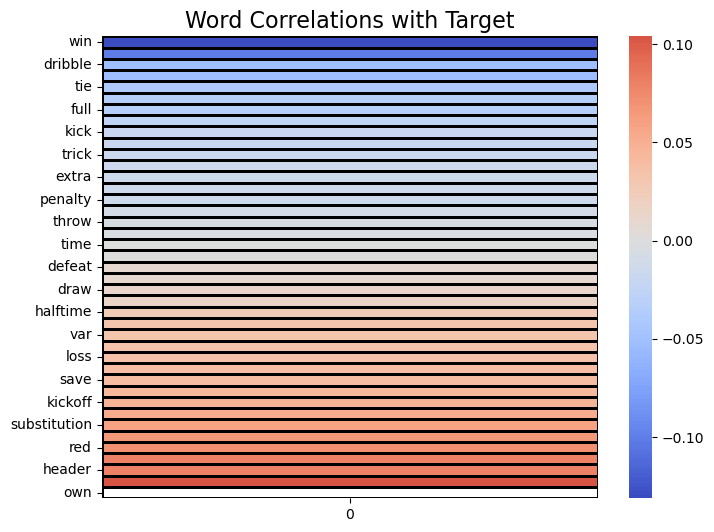

In [63]:

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_words, 
    # annot=True,          # Annotate with correlation values
    cmap='coolwarm',     # Colormap for positive/negative values
    center=0,            # Center the colormap at 0
    linewidths=1,        # Add lines between cells
    linecolor='black'    # Line color
)

plt.title('Word Correlations with Target', fontsize=16)
plt.show()